In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_encoded_scaled = pd.read_csv('data/data_encoded_scaled.csv')
data_cleaned = pd.read_csv('data/data_cleaned.csv')
data_feature = data_cleaned.drop(columns=['TOTAL_DELAY', 'DEP_DEL15'])
data_target = data_cleaned['DEP_DEL15']

In [3]:
data_encoded_scaled = data_encoded_scaled.drop(columns=['DEP_DEL15'])

In [4]:
sequence_days = 7
daily_counts = data_feature.groupby(['MONTH', 'DAY_OF_MONTH', 'DEPARTING_AIRPORT']).size()
average_rows = daily_counts.mean()

print(average_rows*sequence_days)

27.968432919954903


In [5]:
data_full = data_encoded_scaled.assign(TARGET=data_target.values)

In [6]:
print(data_full.head())

   MONTH  DAY_OF_MONTH  DAY_OF_WEEK  DEP_TIME_BLK  DISTANCE_GROUP  \
0    0.0           0.0     0.166667      0.166667        0.428571   
1    0.0           0.0     0.166667      0.166667        0.428571   
2    0.0           0.0     0.166667      0.166667        0.428571   
3    0.0           0.0     0.166667      0.166667        0.428571   
4    0.0           0.0     0.166667      0.166667        0.285714   

   SEGMENT_NUMBER  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  AIRPORT_FLIGHTS_MONTH  \
0           0.000            0.098592              1.0               0.115453   
1           0.000            0.098592              1.0               0.115453   
2           0.000            0.112676              1.0               0.111384   
3           0.000            0.267606              1.0               0.333661   
4           0.125            0.042254              1.0               0.028528   

   AIRLINE_FLIGHTS_MONTH  ...  PREVIOUS_AIRPORT_4  PREVIOUS_AIRPORT_5  \
0               0.183515 

In [7]:
import numpy as np

sequence_length = int(round(average_rows*sequence_days))

unique_dep_airport = data_feature['DEPARTING_AIRPORT'].unique()
unique_flight_number = data_feature['FLIGHT_NUMBER'].unique()

X_sequences = []
y_targets = []

for dep_airport in unique_dep_airport:
    flight_data = data_full[data_feature['DEPARTING_AIRPORT'] == dep_airport]
    flight_data_values = flight_data.iloc[:, :-1].values
    flight_data_target = flight_data.iloc[:, -1].values
    for i in range(len(flight_data) - sequence_length):
        X_sequences.append(flight_data_values[i:i+sequence_length])
        y_targets.append(flight_data_target[i+sequence_length])

X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

print("Input sequences shape:", X_sequences.shape)
print("Target values shape:", y_targets.shape)

Input sequences shape: (41100, 28, 33)
Target values shape: (41100,)


In [8]:
from sklearn.model_selection import train_test_split

data = list(zip(X_sequences, y_targets))

# Shuffle the data
np.random.shuffle(data)

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2)

# Separate the sequences and targets
X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

# Convert the results back to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [9]:
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import SimpleRNN, Dense
from tensorflow.keras.metrics import Recall
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam
import numpy as np

timesteps = X_train.shape[1]
input_dim = X_train.shape[2]

weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train) , y = y_train)
class_weights = dict(zip(np.unique(y_train), weights))

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import Recall
from keras.optimizers import Adam

# Define the LSTM model
model = Sequential()

model.add(LSTM(32, input_shape=(timesteps, input_dim),
               kernel_regularizer=regularizers.l2(0.01),
               recurrent_regularizer=regularizers.l2(0.01),
               bias_regularizer=regularizers.l2(0.01),
               dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', Recall()])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

checkpoint = ModelCheckpoint('model/best_model_hybrid_lstm.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint], class_weight=class_weights)


Epoch 1/300


822/822 [==============================] - ETA: 0s - loss: 1.4986 - accuracy: 0.4816 - recall: 0.6199
Epoch 1: val_loss improved from inf to 1.24642, saving model to model\best_model_hybrid_lstm.h5
822/822 [==============================] - 15s 15ms/step - loss: 1.4986 - accuracy: 0.4816 - recall: 0.6199 - val_loss: 1.2464 - val_accuracy: 0.5044 - val_recall: 0.6469
Epoch 2/300
 10/822 [..............................] - ETA: 9s - loss: 1.2039 - accuracy: 0.5344 - recall: 0.7647 

e:\Semester 3\Deep Learning\flight_delay\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


820/822 [============================>.] - ETA: 0s - loss: 1.1169 - accuracy: 0.5080 - recall: 0.6437
Epoch 2: val_loss improved from 1.24642 to 1.01227, saving model to model\best_model_hybrid_lstm.h5
822/822 [==============================] - 12s 15ms/step - loss: 1.1165 - accuracy: 0.5081 - recall: 0.6429 - val_loss: 1.0123 - val_accuracy: 0.5395 - val_recall: 0.6077
Epoch 3/300
817/822 [============================>.] - ETA: 0s - loss: 0.9656 - accuracy: 0.5169 - recall: 0.6254
Epoch 3: val_loss improved from 1.01227 to 0.92071, saving model to model\best_model_hybrid_lstm.h5
822/822 [==============================] - 11s 13ms/step - loss: 0.9653 - accuracy: 0.5167 - recall: 0.6259 - val_loss: 0.9207 - val_accuracy: 0.5199 - val_recall: 0.6419
Epoch 4/300
822/822 [==============================] - ETA: 0s - loss: 0.8921 - accuracy: 0.5281 - recall: 0.6291
Epoch 4: val_loss improved from 0.92071 to 0.88514, saving model to model\best_model_hybrid_lstm.h5
822/822 [===================

In [11]:
# Make predictions using the model
best_model = load_model('model/best_model_hybrid_lstm.h5')

predictions = best_model.predict(X_test)

# Compare the predictions with the actual values
comparison = pd.DataFrame({'Prediction': predictions.flatten(), 'Actual': y_test})

# Print the comparison
print(comparison)
predictions_labels = [1 if p > 0.5 else 0 for p in predictions.flatten()]

257/257 [==============================] - 1s 4ms/step
      Prediction  Actual
0       0.478685       0
1       0.309808       0
2       0.535298       0
3       0.496480       0
4       0.496179       0
...          ...     ...
8215    0.507135       0
8216    0.545234       0
8217    0.550317       0
8218    0.561816       0
8219    0.294682       0

[8220 rows x 2 columns]


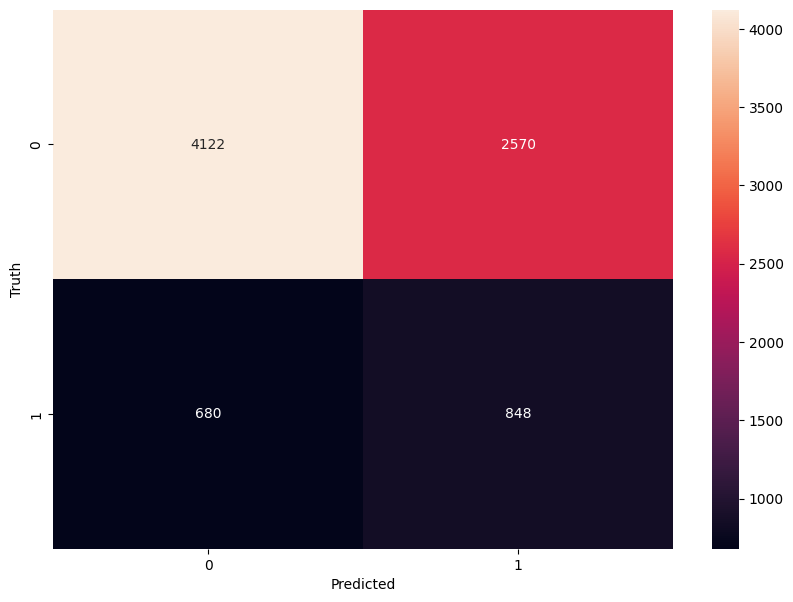

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, predictions_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [13]:
report = classification_report(y_test, predictions_labels, output_dict=True)
print(classification_report(y_test, predictions_labels))
df = pd.DataFrame(report).transpose()
df.to_csv('result/hybrid_lstm.csv')

              precision    recall  f1-score   support

           0       0.86      0.62      0.72      6692
           1       0.25      0.55      0.34      1528

    accuracy                           0.60      8220
   macro avg       0.55      0.59      0.53      8220
weighted avg       0.74      0.60      0.65      8220

